In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Bitstream Vera Sans",
#    "font.sans-serif": "Helvetica",
})

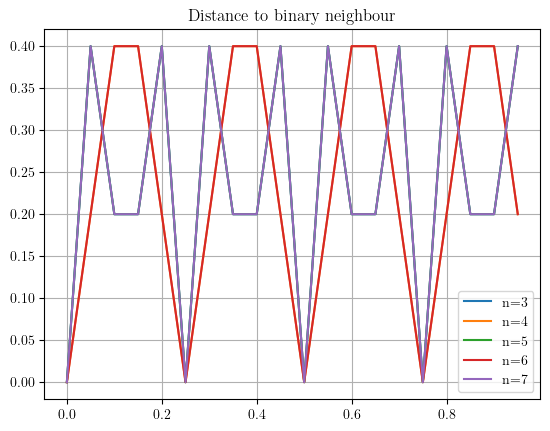

In [2]:
a = [i/20 for i in range(20)]

def dist(a: list, t: int):
    binaries = [i*2**(-t) for i in range(2**t+1)]
    distance = []
    for i in a:
        distance.append(1)
        for j in binaries:
            if np.abs(i-j) < distance[a.index(i)]:
                distance[a.index(i)] = np.abs(i-j)
        distance[a.index(i)] = distance[a.index(i)]/(2**(-t))
    return distance

hmm3 = dist(a, 3)
hmm4 = dist(a, 4)
hmm5 = dist(a, 5)
hmm6 = dist(a, 6)
hmm7 = dist(a, 7)



plt.plot(a, hmm3, label="n=3")
plt.plot(a, hmm4, label="n=4")
plt.plot(a, hmm5, label="n=5")
plt.plot(a, hmm6, label="n=6")
plt.plot(a, hmm7, label="n=7")
plt.legend()
plt.grid()
plt.title("Distance to binary neighbour")
plt.show()

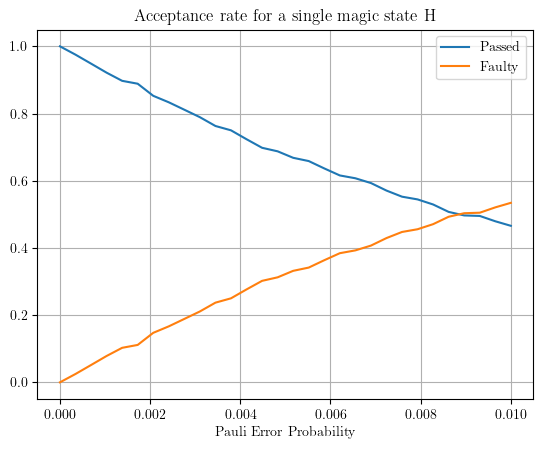

In [3]:
def magicH():  
    qc = QuantumCircuit(7+2,)
    state_inj = ClassicalRegister(14)
    qc.add_register(state_inj)

    anc = qc.num_qubits - 1
    ancc = anc - 1

    for i in range(9):                        #start noise
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.ry(np.pi/4,2)
    qc.h(3)

    qc.cx(2,4)
    qc.cx(0,6)

    qc.cx(3,5)

    qc.cx(2,5)

    qc.cx(0,4)
    qc.cx(1,6)

    qc.cx(0,2)

    qc.cx(1,5)

    qc.cx(1,2)
    qc.cx(3,4)
    qc.cx(3,6)
    #################################Controlled Hadamards##########################################
    qc.h(ancc)
    for i in range(7):
        #qc.ch(anc-1,6-i+2*7)
        qc.ry(-np.pi/4,6-i)
        qc.cz(ancc,6-i)
        qc.ry(np.pi/4,6-i)
        if i == 0:
            qc.cx(ancc,anc)
        if i == 5:
            qc.cx(ancc,anc)
    qc.h(ancc)
    qc.measure(ancc, state_inj[0])
    qc.measure(anc, state_inj[1])
    ##########################################QEC Block#######################################
    qc.reset(anc), qc.reset(ancc)
    ##################################Z-Stabilizers##########################################
    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(0, anc)
    qc.cx(2, anc)
    qc.cx(4, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[2]), qc.measure(ancc, state_inj[8])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(1, anc)
    qc.cx(2, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[3]), qc.measure(ancc, state_inj[9])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(3, anc)
    qc.cx(4, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[4]), qc.measure(ancc, state_inj[10])
    qc.reset(anc), qc.reset(ancc)
    ##################################X-Stabilizers##############################################
    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, 0)
    qc.cx(anc, 2)
    qc.cx(anc, 4)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[5]), qc.measure(ancc, state_inj[11])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 1)
    qc.cx(anc, 2)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[6]), qc.measure(ancc, state_inj[12])
    qc.reset(anc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 3)
    qc.cx(anc, 4)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[7]), qc.measure(ancc, state_inj[13])
    return qc

def testreadout(qc: QuantumCircuit, shots: int, noise: float):
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "id", "ry"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx',"cz"])  # Apply to 2-qubit gates
    
    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    bits = list(counts.keys())
    hmm = list(counts.values())

    nah, valid = 0,0

    for i in range(len(bits)):
        if bits[i].count("1") != 0:
            bits[i] = "nope"
            nah += hmm[i]
        else:
            valid += hmm[i]
    
    nah = nah/shots
    valid = valid/shots

    return valid, nah

qc = magicH()

y,z = [],[]

x = np.linspace(0,0.01,30)
for i in x:
    qc = magicH()
    yes, ney = testreadout(qc, 10000, i)
    y.append(yes), z.append(ney)

plt.plot(x,y,label="Passed")
plt.plot(x,z,label="Faulty")
plt.xlabel("Pauli Error Probability")
plt.grid()
plt.title("Acceptance rate for a single magic state H")
plt.legend()
plt.show()

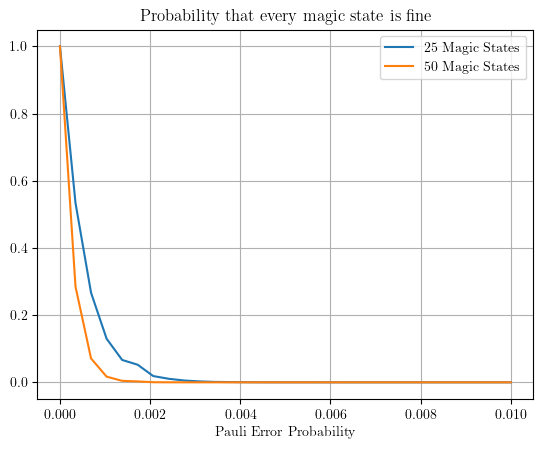

In [4]:
y25 = [i**25 for i in y]

y50 = [i**50 for i in y]

plt.plot(x,y25,label="25 Magic States")
plt.plot(x,y50,label="50 Magic States")
plt.grid()
plt.xlabel("Pauli Error Probability")
plt.legend()
plt.title("Probability that every magic state is fine")
plt.show()

In [5]:
#erste iteration mit 0.3, ideal case ohne noise

def U2(qc: QuantumCircuit, pos: int):
    gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
    #gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg']
    for i in gate:
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)
        if i == "h":
            qc.h(pos)

def adjU2(qc: QuantumCircuit, pos: int):
    gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
    #gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg']
    gate.reverse()
    for i in gate:
        if i == "sdg":
            qc.s(pos)
        if i == "s":
            qc.sdg(pos)
        if i == "t":
            qc.tdg(pos)
        if i == "tdg":
            qc.t(pos)
        if i == "h":
            qc.h(pos)

def CU_L(qc: QuantumCircuit):
    U2(qc, 0)
    U2(qc, 1)
    qc.cx(0,1)
    adjU2(qc, 1)
    qc.cx(0,1)

    # qc.rz(2*np.pi*0.15,0)
    # qc.rz(2*np.pi*0.15,1)
    # qc.cx(0,1)
    # qc.rz(-2*np.pi*0.15,1)
    # qc.cx(0,1)

qr = QuantumRegister(2,"q")
cbit = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbit)

qc.x(1)
qc.h(0)

for i in range(1):
    CU_L(qc)

qc.sdg(0)
# qc.tdg(0)
#qc.z(0)
#qc.rz(-np.pi/8,0)

qc.h(0)

qc.measure(0,0)

shots = 100000

sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

hits = list(counts.values())
bit = list(counts.keys())

one = 0
for i in range(len(bit)):
    if bit[i] == "0":
        one += hits[i]

print(counts)

print("Succesrate: ", one/shots)

{'1': 3173, '0': 96827}
Succesrate:  0.96827


In [84]:
def randomU(n: int):
    u, adju = [],[]
    degah = np.linspace(0,1,n)
    degah = np.delete(degah, [n-1])
    degah = np.delete(degah, [0])
    for k in degah:
        qc = QuantumCircuit(1)
        qc.rz(2*np.pi*(k/2), 0)
        skd = SolovayKitaev(recursion_degree=1)
        discretized = skd(qc)

        hmm = discretized.data
        h = 0
        t = 0
        decomp = []

        for instruction in hmm:
            if instruction.name == "h":
                h+=1
                decomp.append("h")
            if instruction.name == "t":
                t+=1
                decomp.append("t")
            if instruction.name == "tdg":
                t+=1
                decomp.append("tdg")
            #print(instruction.name)

        # print("h: ",h, ", t/tdg: ",t)
        # print(decomp)
        for i in range(len(decomp)-1):
            if decomp[i] == decomp[i+1]:
                if decomp[i] == "t":
                    decomp[i+1] = "s"
                    decomp [i] = 0
                if decomp[i] == "tdg":
                    decomp[i+1] ="sdg"
                    decomp [i] = 0
        try:
            decomp.remove(0)
        except ValueError:
            True

        decomp = [i for i in decomp if i != 0]

        for i in range(len(decomp)-1):
            if decomp[i] == decomp[i+1]:
                if decomp[i] == "s":
                    decomp[i+1] = "z"
                    decomp [i] = 0
                if decomp[i] == "sdg":
                    decomp[i+1] ="z"
                    decomp [i] = 0
        try:
            decomp.remove(0)
        except ValueError:
            True

        decomp = [i for i in decomp if i != 0]
        # print("h: ",decomp.count("h"), " t/tdg: ", decomp.count("t")+decomp.count("tdg"))
        # print(decomp)
        nah = decomp.copy()
        u.append(nah)
        decomp.reverse()
        for i in range(len(decomp)):
            if decomp[i] == "t":
                decomp[i] = "tdg"
                continue
            if decomp[i] == "tdg":
                decomp[i] = "t"
                continue
            if decomp[i] == "s":
                decomp[i] = "sdg"
                continue
            if decomp[i] == "sdg":
                decomp[i] = "s"
                continue
        # print("U nachher: ",u)
        adju.append(decomp)

    return u, adju, degah

a,b, angles = randomU(10)

print("U:", a)
print("adjU:", b)

# data = np.array((a,b))
# np.savetxt("tessst.txt", data)

U: [['h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 't'], ['t'], ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg'], ['s', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg'], ['s', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg'], ['z', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg'], ['s', 't'], ['z', 't', 'h', '

In [86]:
#erste iteration mit 0.3, ideal case ohne noise

def U2(qc: QuantumCircuit, pos: int, gate: list):
    for i in gate:
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)
        if i == "h":
            qc.h(pos)

def CU_L(qc: QuantumCircuit, Ugates: list, adjUgates: list):
    U2(qc, 0, Ugates)
    U2(qc, 1, Ugates)
    qc.cx(0,1)
    U2(qc, 1, adjUgates)
    qc.cx(0,1)

    # qc.rz(2*np.pi*0.15,0)
    # qc.rz(2*np.pi*0.15,1)
    # qc.cx(0,1)
    # qc.rz(-2*np.pi*0.15,1)
    # qc.cx(0,1)

angles = np.linspace(0,1,100)
angles = np.delete(angles, [100-1])
angles = np.delete(angles, [0])

qr = QuantumRegister(2,"q")
cbit = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbit)

qc.x(1)
qc.h(0)

for i in range(4):
    CU_L(qc, a, b)

#qc.sdg(0)
#qc.tdg(0)
#qc.z(0)
#qc.rz(-np.pi/8,0)

qc.h(0)

qc.measure(0,0)

shots = 10

sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

hits = list(counts.values())
bit = list(counts.keys())

one = 0
for i in range(len(bit)):
    if bit[i] == "0":
        one += hits[i]

print(counts)

print("Succesrate: ", one/shots)

{'0': 10}
Succesrate:  1.0


In [92]:
a,b,angle = randomU(5+2)

for p in range(len(a)):
    print(p)

0
1
2
3
4


In [ ]:
def convert(bin: str):                  #konvertiert den bitstring in deciaml, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def Leon(iter: int, angles: int, noise: float):
    a,b,angle = randomU(angles+2)               #0 und 1 werden rausgenommen
    y = 0
    for o in range(len(a)):
        bitstring = ""
        rots = []
        for i in range(1,iter+1,1):
            rots = [i*0.5 for i in rots]
            qr = QuantumRegister(2,"q")
            cbit = ClassicalRegister(1, "c")
            qc = QuantumCircuit(qr, cbit)
            p = noise
            p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
            p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "t", "tdg", "rz"])  # Apply to single-qubit gates
            noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
            qc.x(1)
            qc.h(0)
            for i in range(iter-i):
                CU_L(qc, a, b)

            for i in rots:
                qc.rz(-np.pi*(i),1)

            qc.h(0)
            qc.measure(0,0)

            shots = 1
            sim = AerSimulator()
            job = sim.run(qc, shots=shots)
            result = job.result()
            counts = result.get_counts()
            bit = list(counts.keys())

            if bit[0] == "0":
                bitstring += "0"
            else:
                bitstring += "1"
                rots.append(0.5)

        value = convert(bitstring)
        diff = np.abs(value-angle[o])
        y += diff
    y = y/angles
    return y

p = np.linspace(0,0.01,10)

y_all = []

for i in p:
    ok = Leon(3, 10, i)
    y_all.append(ok)

plt.plot(p,y_all)
plt.show()

NameError: name 'y' is not defined

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


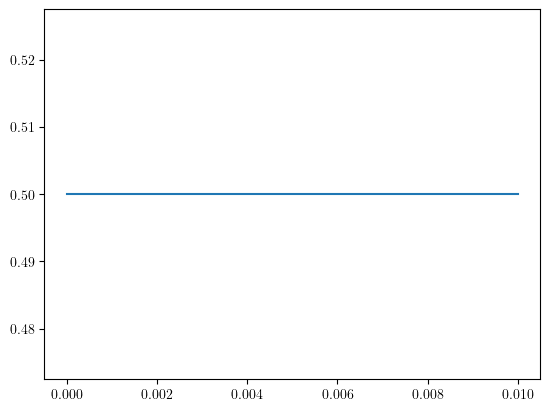

In [ ]:
print(y_all)
plt.plot(p,y_all)
plt.show()

A = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]  # Beispiel-Liste

with open("output.txt", "w") as file:
    for i in A:
        file.write(",".join(map(str, i)) + "\n")

print("Datei wurde erfolgreich gespeichert.")

Ehm = []
with open("output.txt", "r") as file:
    for line in file:
        Ehm.append(list(map(int, line.strip().split(","))))

print(Ehm)  # Gibt die rekonstruierte Liste aus

In [5]:
i = 0.5

qc = QuantumCircuit(1)

qc.rz(2*np.pi*(i/2), 0)
        
skd = SolovayKitaev(recursion_degree=1)

discretized = skd(qc)

print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

Discretized circuit:
global phase: 7π/4
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
Error: 4.002966042486721e-16
